In [ ]:
# %%bash

# cat > requirements.txt << EOF
# numpy==1.16.3
# matplotlib==3.0.3
# scipy==1.3.0
# pymc3==3.6
# arviz==0.4.0
# pandas==0.24.2
# pystan==2.19.0.0
# EOF

# pip install -r requirements.txt


In [ ]:
# import logging
# _logger = logging.getLogger("theano.gof.compilelock")
# _logger.setLevel(logging.ERROR)
# !pip install pymc3>=3.8

In [ ]:
import numpy as np
import pandas as pd
import random
import math
import sys
import matplotlib.pyplot as plt
from numpy import linalg as LA
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import uniform
from scipy.optimize import minimize_scalar
import pymc3 as pm
%matplotlib inline
from IPython.core.pylabtools import figsize
from pymc3 import find_MAP,Metropolis
import theano
import theano.tensor as tt

https://sjster.github.io/introduction_to_computational_statistics/docs/Production/PyMC3.html

# Codes From Other Places

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

https://seaborn.pydata.org/generated/seaborn.distplot.html

**Generate some data**

20 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean mu (we'll assume that we know the standard deviation to be 1).

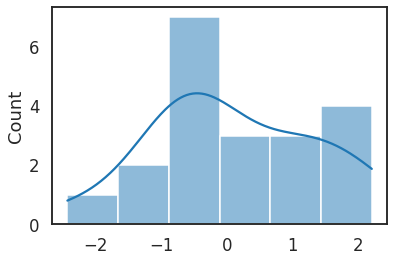

In [ ]:
# Selecting style as white, dark, whitegrid, darkgrid or ticks
sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)
data = np.random.randn(20)
ax = plt.subplot()
#kde: Add a kernel density estimate to smooth the histogram, providing complementary information about the shape of the distribution:
sns.histplot(data,kde=True,ax=ax)

**define our model**
*   **likelihood of the model is normal**: assume that this data is normal distributed; based on the graph.

A normal distribution has two parameters -- mean μ and standard deviation σ. For simplicity, assume we know that σ=1 and want to infer the posterior for μ. 
*   **For each parameter we want to infer, we have to choose a prior.** For simplicity, let us assume a Normal distribution as a prior for μ. 

**For this model, we can compute the posterior analytically**. That's because for a normal likelihood with known standard deviation, the normal prior for mu is conjugate (conjugate here means that our posterior will follow the same distribution as the prior). We know that our posterior for μ is also normal.



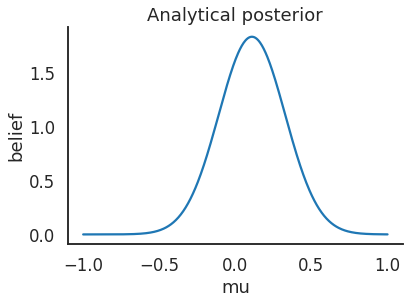

In [ ]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

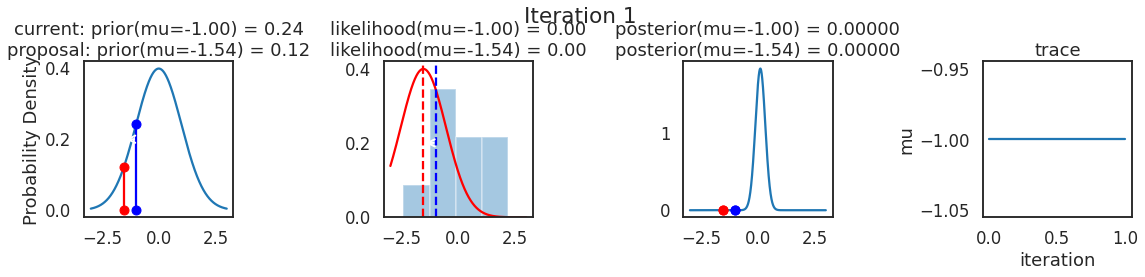

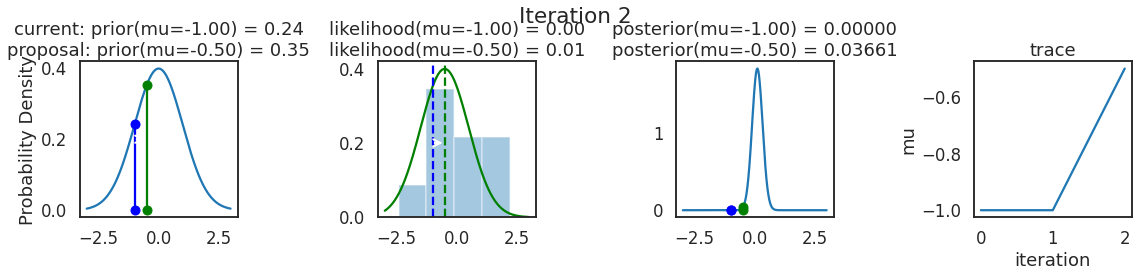

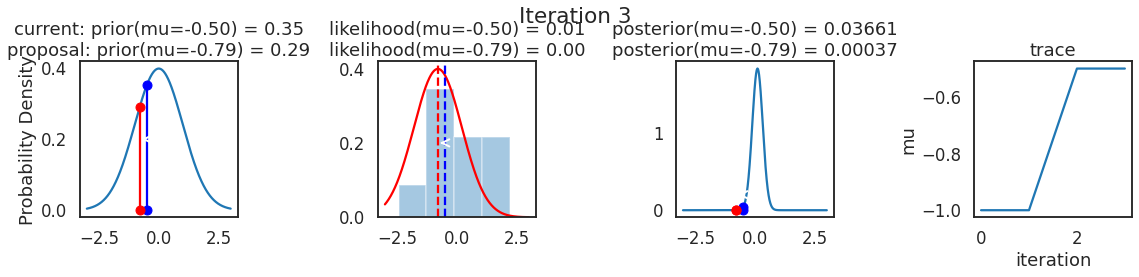

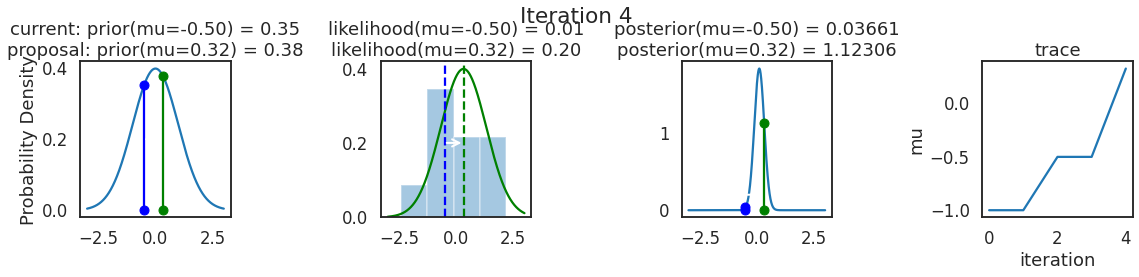

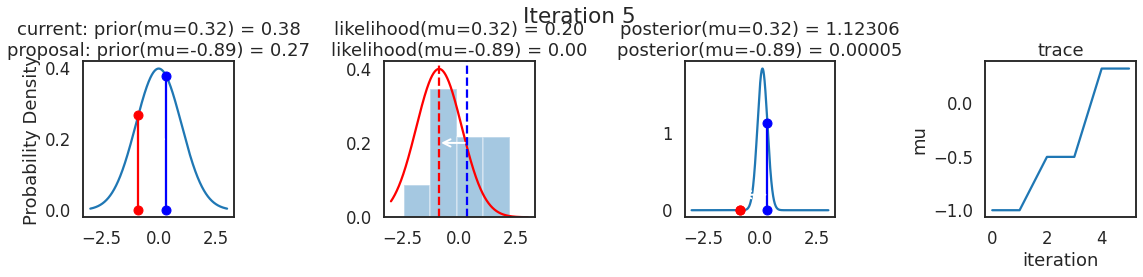

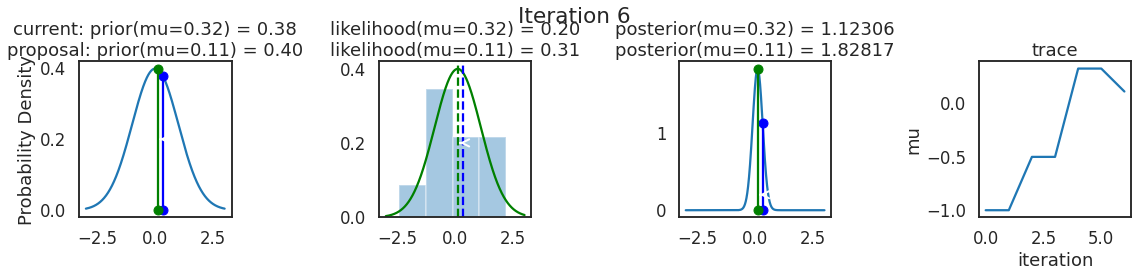

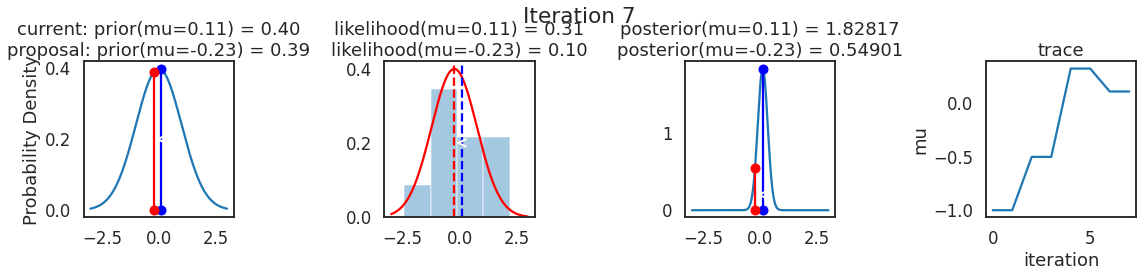

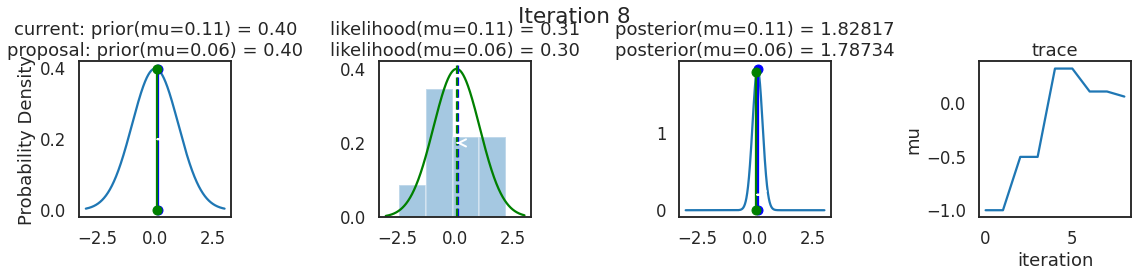

In [ ]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init#find starting parameter position (can be randomly chosen)
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior: what our belief about μ is before seeing the data. 
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior: our likelihood and what we are using to evaluate how good our model explains the data
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);


PyMC3: do numerical Bayesian inference


*   https://people.duke.edu/~ccc14/sta-663/PyMC3.html
*   https://towardsdatascience.com/introduction-to-pymc3-a-python-package-for-probabilistic-programming-5299278b428
*   https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb



Let’s assume that we have a coin. We flip it three times and the result is:
[0, 1, 1] where 0 means that the coin lands in a tail and 1 means that the coin lands in a head. Are we confident in saying that this is a fair coin? 

From the **frequentist-perspective**, a point estimation for θ would be $\theta=\frac{number of heads}{total number of trails}=\frac{2}{3}$. While this number makes sense, the frequentist approach does not really provide a certain level of confidence about it. In particular, if we do more trials, we are likely to get different point estimations for θ.

This is where the Bayesian approach could offer some improvement. The idea is simple, as we do not know anything about θ, we can assume that θ could be any value on [0,1]. Mathematically, our prior belief is that θ follows a Uniform(0,1) distribution. We can then use evidence/our observations to update our belief about the distribution of θ.

Let us formally call D to be the evidence. By the Bayesian rule, the posterior distribution is compueted by $P(\theta | D)=\frac{P(D|\theta)P(\theta)}{\int P(D|\theta)P(\theta)d \theta}$ where $P(D|θ)$ is the likelihood function, P(θ) is the prior distribution, and $\int P(D|\theta)P(\theta)d \theta$ is a normalizing constant.

In Bayesian probability theory, if the posterior distribution p(θ | x) is in the same probability distribution family as the prior probability distribution p(θ), the prior and posterior are then called **conjugate distributions**, and the prior is called a conjugate prior for the likelihood function p(x | θ).


In [ ]:

with pm.Model() as model:
    theta=pm.Uniform('theta', lower=0, upper=1)# initiate the prior distribution for θ

occurrences=np.array([1,1,0]) #our observation 
with model:
    obs=pm.Bernoulli("obs",p=theta,observed=occurrences,) #input the observations

    # start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step=pm.Metropolis()#PyMC3 uses the Metropolis-Hastings algorithm to approximate the posterior distribution
    trace=pm.sample(18000, step=step)#The trace function determines the number of samples withdrawn from the posterior distribution.
    burned_trace=trace[1000:]#as the algorithm might be unstable at the beginning, it is useful to only withdraw samples after a certain period of iterations.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 18_000 draw iterations (2_000 + 36_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


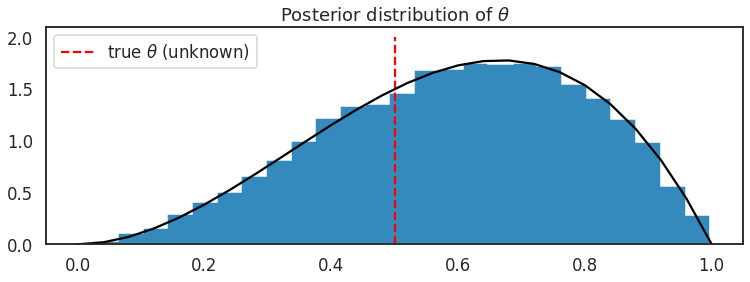

As we can clearly see, the numerical approximation is pretty close to the true posterior distribution.


In [ ]:
from IPython.core.pylabtools import figsize
p_true=0.5
figsize(12.5, 4)
plt.title(r"Posterior distribution of $\theta$")
plt.vlines(p_true,0, 2, linestyle='--', label=r"true $\theta$ (unknown)", color='red')
plt.hist(burned_trace["theta"], bins=25, histtype='stepfilled', density=True, color='#348ABD')
x=np.arange(0,1.04,0.04)
plt.plot(x, 12*x*x*(1-x), color='black')#true posterior distribution.
plt.legend()
plt.show()

print("As we can clearly see, the numerical approximation is pretty close to the true posterior distribution.")

**What happens if we increase the sample size?**

As we mentioned earlier, the more data we get, the more confident we are about the true value of θ. Let us test our hypothesis by a simple simulation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 18_000 draw iterations (2_000 + 36_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


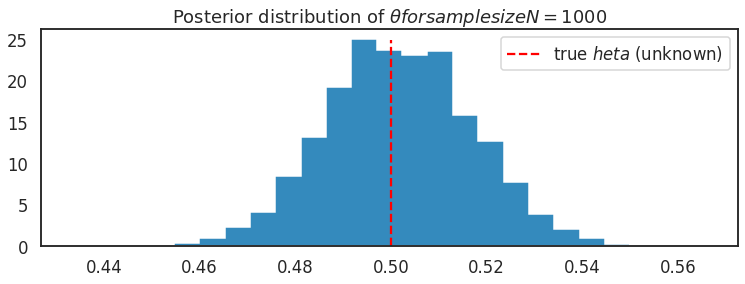

As we can see, the posterior distribution is now centered around the true value of θ.


In [ ]:
N=1000 #the number of samples
occurences1=np.random.binomial(1, p=0.5, size=N)
k=occurences1.sum() #the number of heads

#fit the observed data 
with pm.Model() as model1:
    theta=pm.Uniform('theta', lower=0, upper=1)
with model1:
    obs=pm.Bernoulli("obs", theta, observed=occurences1)
    step=pm.Metropolis()
    trace=pm.sample(18000, step=step)
    burned_trace1=trace[1000:]


#plot the posterior distribution of theta. 
p_true=0.5
figsize(12.5, 4)
plt.title(r"Posterior distribution of $\theta for sample size N=1000$")
plt.vlines(p_true,0, 25, linestyle='--', label="true $\theta$ (unknown)", color='red')
plt.hist(burned_trace1["theta"], bins=25, histtype='stepfilled', density=True, color='#348ABD')
plt.legend()
plt.show()
print("As we can see, the posterior distribution is now centered around the true value of θ.")

# Markov Chain
$(X_n)_{n\ge0}$ is sequence of random variables 

where support($x_i$)={1,2...s}->values called states

$p(x_{n+1}=i_{n+1}|x_0=i_0,x_1=i_1...x_n=i_n)=p(x_{n+1}=i_{n+1}|x_n=i_n)$

"to predict the future: you only need to know the present, not how you get to the present"

https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb

No handles with labels found to put in legend.


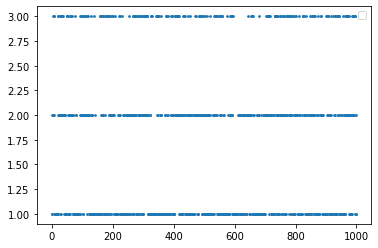

the number of sunny days= 465
the number of cloudy days= 322
the number of rainy days= 213


In [ ]:
#example: weather; there are three states: sunny, cloudy, and rainy
df=pd.DataFrame(np.zeros((3,3)),['sunny','cloudy','rainy'],['sunny','cloudy','rainy'])
df['sunny']=[0.7,0.3,0.2]
df['cloudy']=[0.2,0.4,0.5]
df['rainy']=[0.1,0.3,0.3]

A=np.array([[0.7,0.2,0.1],[0.3,0.4,0.3],[0.2,0.5,0.3]])
n=1000


#create a numpy arrays of NaN
x=np.empty(n)
x[:]=np.NAN
x[0]=1#sunny:1; cloudy:2; rainy: 3; set initial state to 1
for i in range(1,n):
  for j in range(1,4):#1,2,3
    if x[i-1]==1:
      x[i]=np.random.choice([1,2,3],size=1,p=[0.7,0.2,0.1])
    elif x[i-1]==2:
      x[i]=np.random.choice([1,2,3],size=1,p=[0.3,0.4,0.3])
    else:
      x[i]=np.random.choice([1,2,3],size=1,p=[0.2,0.5,0.3])


plt.scatter(np.arange(0,n),x,s=3)
plt.legend()
plt.show()

print("the number of sunny days=",sum(x==1))
print("the number of cloudy days=",sum(x==2))
print("the number of rainy days=",sum(x==3))

# Markov Chain Convergence
Definition of stochatic matrix:

A transition matrix P=d x d satisfies the following properties:

*   Rows of P sum to 1, ie $\sum_{k=1}^{s}P_{i,k}=1$ for all i
*   All entries are non-negative $P_{i,j}\ge0$ for all i,j
-----------------------
let $P \in R^{dxd}$ be a stochatic matrix, $P^n$, the transition matrix P to the power of n, converges as n approaches infinity; more precisely, $P^n->L$, where $L=\left[
\begin{array}{ccc}
\Pi _1 & \Pi _2 & ... & \Pi _d \\
\Pi _1 & \Pi _2 & ...&  \Pi _d\\
... & ... & ...&  ...\\
\Pi _1 & \Pi _2 & ...&  \Pi _d
\end{array}
\right]$

regarless of i(starting state) and n(times), $p(x_n=j|x_0=i)\approx\Pi_j$(assume n is "big")

**Matrix to a power of 50: $P^{50}$**

In [ ]:
#stochastic array: initial
a = np.array([[0.7,0.2,0.1], 
              [0.3,0.4,0.3],
              [0.2,0.5,0.3]])


B=np.array([[0.7,0.2,0.1], 
              [0.3,0.4,0.3],
              [0.2,0.5,0.3]])
for i in range(0,50):
  B=np.matmul(B,a)

print("matrix to a power of 50")
print(B)

matrix to a power of 50
[[0.46551724 0.32758621 0.20689655]
 [0.46551724 0.32758621 0.20689655]
 [0.46551724 0.32758621 0.20689655]]


**Eigenvalues of P**

linalg.eig(a) computes the eigenvalues and right eigenvectors of a square array.

write 
$\lim_{x\to \infty}P^n =L=\left[
\begin{array}{ccc}
\Pi _1 & \Pi _2 & ... & \Pi _d \\
\Pi _1 & \Pi _2 & ...&  \Pi _d\\
... & ... & ...&  ...\\
\Pi _1 & \Pi _2 & ...&  \Pi _d
\end{array}
\right]=\left[
\begin{array}{ccc}
\ ---& \Pi & --- \\
\ --- & \Pi & ---\\
... & ... & ...\\
\ --- & \Pi  & ---
\end{array}
\right]$

let $\Pi=(\Pi_1,\Pi_2...\Pi_d)$, called "limiting distribution"
1. $\sum_{i=1}^{d}\Pi_i=1$; the product of stochastic matrix is stochastic
2.$\Pi$ is a left eigenvector of P with x=1, meaning that $\Pi P=\Pi$. Alternatively, $\Pi$ is an eigenvector with $\lambda=1$ of $P^t$

$P^{n+1}=P^n P$

As $n->\infty$, we have L=LP so $L^t=P^t L^t=P^t \left[
\begin{array}{ccc}
\ |& | & ... & | \\
\ \Pi & \Pi & ... & \Pi\\
\ |& | & ... & |
\end{array}
\right]$.

$\left[
\begin{array}{ccc}
\ |& | & ... & | \\
\ \Pi & \Pi & ... & \Pi\\
\ |& | & ... & |
\end{array}
\right]=P^t \left[
\begin{array}{ccc}
\ |& | & ... & | \\
\ \Pi & \Pi & ... & \Pi\\
\ |& | & ... & |
\end{array}
\right]$

$P^t \Pi=1 \Pi$; we want eigenvector associated with eigenvalue of 1

source: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

In [ ]:
w, v = LA.eig(a.transpose())
print("eigenvalues")
print(w)#print eigenvalues
print("eigenvectors")
print(v)#print eigenvectors

#we only care about eigenvector whose eigenvalue is 1
pi1=v[:,0]/sum(v[:,0])
pi1

eigenvalues
[ 1.          0.44494897 -0.04494897]
eigenvectors
[[ 0.76861027  0.81511137  0.14072662]
 [ 0.5408739  -0.44872717 -0.76688827]
 [ 0.34160457 -0.3663842   0.62616165]]


array([0.46551724, 0.32758621, 0.20689655])

# Markov Chain Monte Carlo

Markov Chain Monte Carlo(MCMC) algorithms are one of the most fundamental algorithms in computation, especially in modern statistics and Bayesian modeling. These algorithms allow you to draw samples from any distribution, discrete, continuous, even higher-dimensional distributions. The samples that are drawn are dependent on the previous ones. However, the Ergodic property of Markov Chains implies that the “Law of Large Numbers” will be applicable for this type of sampling. Therefore, we can study distributions by working with samples from this Markov chain despite the samples being dependent. 

Let us sample from Poisson(2)

https://docs.python.org/3/library/random.html

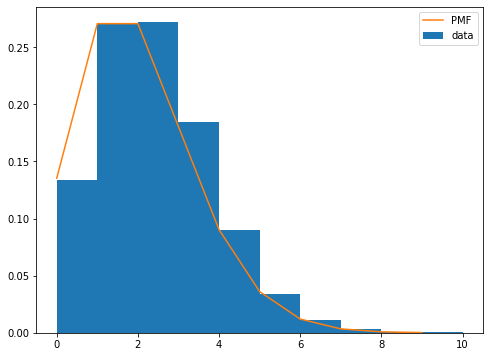

In [ ]:
n=100000#number of samples
M=np.repeat(0,n)#our Markov chain
M[0]=3#intial state
for i in range(1,n):
  proposal=M[i-1]+random.choice([1,-1])
  propP=poisson.pmf(proposal, mu=2, loc=0)#likelihood of the proposal state
  propC=poisson.pmf(M[i-1], mu=2, loc=0)#likelihood of the current state
  r=propP/propC#calculate rho
  M[i]=M[i-1]
  if r>=1:
    M[i]=proposal
  else:
    if random.random()<r:
      M[i]=proposal

x=np.arange(0,10,1)
y=poisson.pmf(x,mu=2,loc=0)
#create a Poisson probability mass function plot in Python
plt.figure(figsize=(8,6))
plt.hist(M,density=True,label="data",bins=10)
plt.plot(x,y,label="PMF")
plt.legend()

Let us sample from continuous distribution

$f_x(s,t)=\sqrt{1-s^2-t^2}$ supported on $s^2+t^2 \le 1$

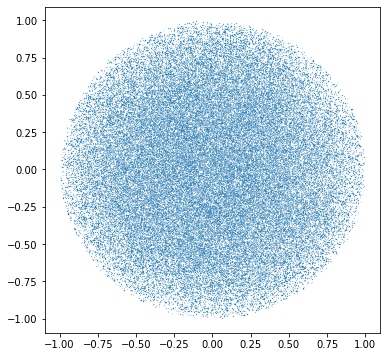

In [ ]:
def f(s,t):
  if s*s+t*t<=1:
    return math.sqrt(1-s*s-t*t)
  else:
    return 0

M=np.zeros((n,2))
M[0,:]=np.array([0,0])#initial state
for i in range(1,n):
  proposal=M[i-1,:]+np.random.normal(0, 0.2, 2)
  propP=f(proposal[0],proposal[1])
  propC=f(M[i-1,0],M[i-1,1])
  r=propP/propC
  M[i,:]=M[i-1,:]#by default, the proposal state is the same as the present state
  if r>=1:
    M[i,:]=proposal
  else:
    if random.random()<r:
      M[i,:]=proposal

plt.figure(figsize=(6,6))
plt.scatter(M[:,0],M[:,1],s=0.01,label="data")

Let us write a general code for MCMC

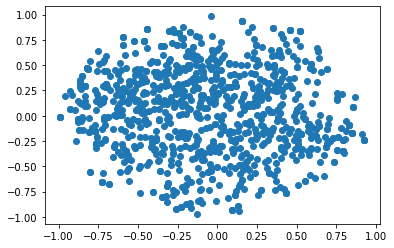

In [ ]:
def MCMC(f,x,n,sd=0.2):
  #f: unnormalized PDF for a multi-dimensional distribution
  #x: starting state of Markov Chain; a vector
  #n: length of Markov Chain
  #sd: default std which is used to move to a proposal state
  d=len(x)#d is the dimension of the starting state vector
  M=np.zeros((n,d))#Markov chain as a matrix of diff samples from the distribution
  M[0,:]=x#set the initial state of Markov Chain
  for i in range(1,n):
    proposal=M[i-1,:]+np.random.normal(0,sd,d)

    #Calculate the prob of proposal state and current state
    propP=f(proposal)
    propC=f(M[i-1,:])
    r=propP/propC
    M[i,:]=M[i-1,:]#by default,the proposal state is the same as current state
    if r>=1:
      M[i,:]=proposal
    else:
      if random.random()<r:
        M[i,:]=proposal
  return M

def func(x):
  s=x[0]
  t=x[1]
  return f(s,t)
A=MCMC(func,np.array([0,0]),1000)
plt.scatter(A[:,0],A[:,1])


# Maximum Likelihood Estimation (MLE) and Maximum A Posteriori (MAP)

Maximum Likelihood Estimation (MLE) and Maximum A Posteriori (MAP) estimation are method of **estimating parameters of statistical models**.
*   MLE is powerful when you have enough data. However, it doesn’t work well when observed data size is small.
*   MAP: $argmax_{\theta} P(\theta | D)=argmax_{\theta} P(D|\theta)P(\theta)$


source: 

https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-and-maximum-a-posteriori-estimation-d7c318f9d22d

**Bayesian inference** is simply updating your beliefs after considering new evidence. Bayesian inference works identically: we update our beliefs about an outcome; rarely can we be absolutely sure unless we rule out all other alternatives. **PyMC3** is a Python library for programming Bayesian analysis. 

a very motivating description of **probabilistic programming**:
> Another way of thinking about this: unlike a traditional program, which only runs in the forward directions, **a probabilistic program is run in both the forward and backward direction.** It runs forward to compute the consequences of the assumptions it contains about the world (i.e., the model space it represents), but it also runs backward from the data to constrain the possible explanations. In practice, many probabilistic programming systems will cleverly interleave these forward and backward operations to efficiently home in on the best explanations.


Let's quickly recall **what a probability distribution is**: Let  be some random variable. Then associated with  is a probability distribution function that assigns probabilities to the different outcomes  can take. Graphically, a probability distribution is a curve where the probability of an outcome is proportional to the height of the curve.

# Posterior Distribution: Data




how to compute $\pi$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom

https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace

estimated pi: 0.7888
exact pi: 0.7853981633974483


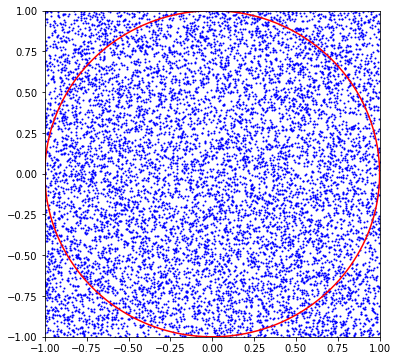

In [ ]:
n=10000
X=np.zeros(n)
Y=np.zeros(n)
r=np.zeros(n)

x1=np.linspace(-1,1,n)
y1=np.zeros(n)
y2=np.zeros(n)

for i in range(0,n):
  X[i]=random.uniform(-1, 1)
  Y[i]=random.uniform(-1, 1)
  y1[i]=math.sqrt(1-x1[i]*x1[i])
  y2[i]=-math.sqrt(1-x1[i]*x1[i])


for i in range(0,n):
  r[i]=math.sqrt(X[i]*X[i]+Y[i]*Y[i])

plt.figure(figsize=(6,6))
plt.scatter(X,Y,c="blue",s=1)
plt.plot(x1,y1,'r')
plt.plot(x1,y2,'r')
plt.xlim(-1,1)
plt.ylim(-1,1)
print("estimated pi:",sum(r<1)/n)
print("exact pi:",math.pi/4)

Generate data for $x$ bernoulli(p) where $p=\pi/4$

estimated pi: 0.65
exact pi: 0.7853981633974483
13.0


array([0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1.])

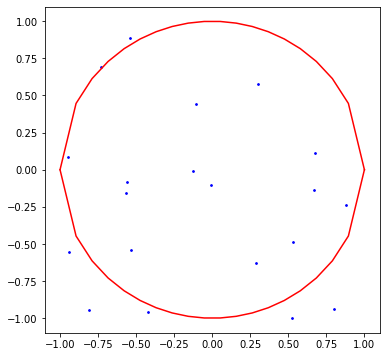

In [ ]:
random.seed(1)
def generate_pi_data(n):
  X=np.zeros(n)
  Y=np.zeros(n)
  r=np.zeros(n)

  x1=np.linspace(-1,1,n)
  y1=np.zeros(n)
  y2=np.zeros(n)

  for i in range(0,n):
    X[i]=random.uniform(-1, 1)
    Y[i]=random.uniform(-1, 1)
    y1[i]=math.sqrt(1-x1[i]*x1[i])
    y2[i]=-math.sqrt(1-x1[i]*x1[i])


  for i in range(0,n):
    r[i]=math.sqrt(X[i]*X[i]+Y[i]*Y[i])
  plt.figure(figsize=(6,6))
  plt.scatter(X,Y,c="blue",s=3)
  plt.plot(x1,y1,'r')
  plt.plot(x1,y2,'r')

  print("estimated pi:",sum(r<1)/n)
  print("exact pi:",math.pi/4)

  #generating data
  data=np.zeros(n)
  for i in range(0,n):
    if r[i]<=1:#inside the circle
      data[i]=1
  return data

data=generate_pi_data(20)
print(sum(data))#make sure it is 13 before continuing bc the the following code assume # of successes is 13
data

# Posterior Distribution: explicit approaches, numerical approaches, Laplace approximation

https://www.mit.edu/~9.520/spring11/slides/class19_approxinf.pdf

**Prior distribution: p has uniform(0,1)**

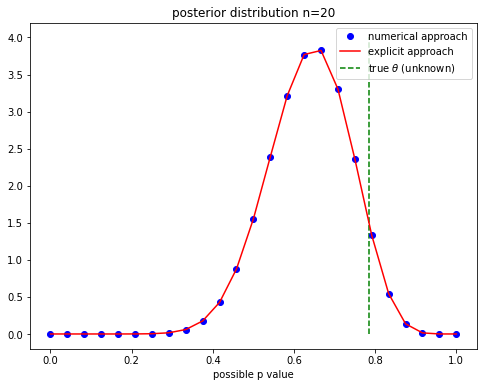

In [ ]:
ps=np.linspace(0,1,25)#possible p values
post=np.zeros(25)#posterior prob for each p given the data
eps=ps[1]-ps[0]

def sum_eachp(data,ps,pi):#here we assume uniform distribution for theta
  n=len(data)
  values=np.zeros(n)
  for i in range(0,n):
    values[i]=binom.logpmf(data[i], 1, ps[pi], loc=0)
  return np.sum(values)+math.log(1)

def exponentiate_array(post):
  n=len(post)
  for i in range(0,n):
    post[i]=math.exp(post[i])
  return post

for i in range(0,25):
  post[i]=sum_eachp(data,ps,i)
post=exponentiate_array(post)
post=post/np.sum(post*eps)

def actual_func(ps):#solve the problem explicitly
  n=len(ps)
  lklhd=np.zeros(n)
  for i in range(0,n):
    p=ps[i]
    lklhd[i]=1627920*(p**13)*((1-p)**7)
  return lklhd

plt.figure(figsize=(8,6))
plt.plot(ps,post,'bo',label="numerical approach")
plt.plot(ps,actual_func(ps),'r',label="explicit approach")
plt.vlines(math.pi/4, 0,4,linestyle='--',label=r"true $\theta$ (unknown)", color='green')
plt.xlabel("possible p value")
plt.title("posterior distribution n=20")
plt.legend()

In addition to solving posterior distribution explicitly(using calculus) or numerically, we can use **Laplace approximation**.

Laplace approximation assumes that the posterior distribution is approximately normal. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html?highlight=uniform#scipy.stats.uniform
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar

In [ ]:
# def L(p):#we are modelling the data using bernoulli
#   n=len(data)
#   values=np.zeros(n)
#   for i in range(0,n):
#     values[i]=binom.logpmf(data[i], 1, p, loc=0)
#   return -np.sum(values)-uniform.logpdf(p, loc=0, scale=1)

# minimize_scalar(L,bounds=(0, 1), method='bounded')
#The bounded method provides a rudimentary interval constraint for scalar functions. 

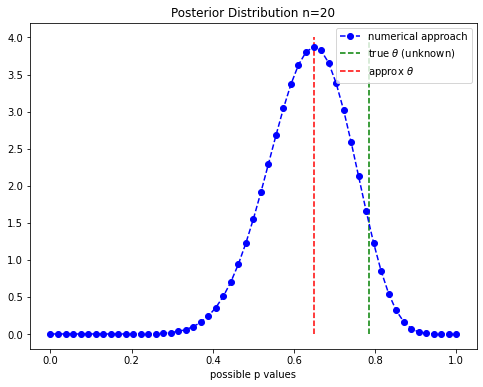

In [ ]:
def likelihood_for_p(data,a,b):#assume we have bernoulli(p) 
  s=np.sum(data)#number of sucesses
  ps=np.linspace(0,1,55)#possible p values
  post=np.zeros(55)#for each prior probability(p) value, we have the following posterior probability
  eps=ps[1]-ps[0]

  for i in range(0,55):
    post[i]=sum_eachp(data,ps,i)#for each p value, we have a posterior probability
  post=exponentiate_array(post)#for numerical reasons, we take the log first and then we exponentiate
  post=post/np.sum(post*eps)#to normalize
  plt.figure(figsize=(8,6))
  plt.plot(ps,post,'bo--',label="numerical approach")
  # plt.plot(ps,actual_func(ps),'r',label="explicit approach")
  plt.vlines(math.pi/4, 0,a,linestyle='--',label=r"true $\theta$ (unknown)", color='green')
  plt.vlines(sum(data)/len(data),0,a,linestyle='--',label=r"approx $\theta$", color='red')
  plt.xlabel("possible p values")
  plt.title(b)
  plt.legend()

likelihood_for_p(data,4,"Posterior Distribution n=20")

(0.0, 1.0)

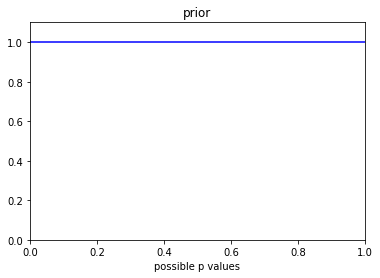

In [ ]:
plt.figure(figsize=(6,4))
plt.axhline(y=1, color='b', linestyle='-')
plt.title("prior")
plt.xlabel("possible p values")
plt.ylim(0,1.1)
plt.xlim(0,1)

estimated pi: 0.772
exact pi: 0.7853981633974483


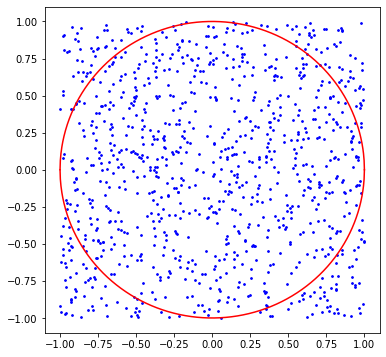

In [ ]:
data1=generate_pi_data(1000)

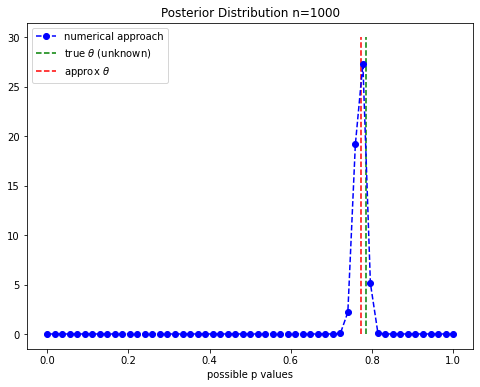

In [ ]:
likelihood_for_p(data1,30,"Posterior Distribution n=1000")

# Posterior Distribution: MCMC

With MCMC, we can draw samples from a distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). Under certain conditions, the Markov chain will have a unique stationary distribution. In addition, not all samples are used because we set up acceptance criteria for each draw by comparing successive states with respect to a target distribution to ensure that the stationary distribution is the posterior distribution of interest. The target distribution only needs to be proportional to the posterior distribution, which means we do not need to evaluate the potentially intractable integral, which is just a normalizing constant. After some time, the Markov chain of accepted draws will converge to the stationary distribution, and we can use those samples as correlated draws from the posterior distribution and find functions of the posterior distribution. 

There is a wonderful package called PyMC3, which allows us to fit Bayesian models using a variety of numerical methods, most notably MCMC and variational inference (VI). Its flexibility and extensibility make it applicable to a large suite of problems.



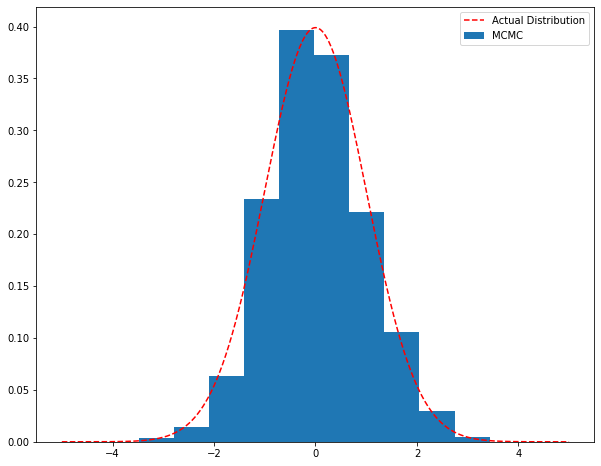

In [ ]:
#uses Metropolis algorithm to construct a Markov Chain 
#that draws samples from the log-likelihood f.
#f represents the log of PDF of a random variable we want to sample from; 
#x is our initial point/vector where we want to start the Markov chain;
#n is the number of samples we want to use; length of Markov Chain;
#sd is used in generating random proposal state.
def lMCMC(f,x,n,sd=0.2):
  if isinstance(x, list):
    d=len(x)#how many parameters a random variable has
  else:
    d=1
  X=np.zeros((n,d))
  X[0,]=x
  for i in range(1,n):
    proposal=X[i-1,]+norm.rvs(loc=0, scale=sd, size=1)#proposal state
    proposalL=f(proposal) #likelihood of proposal state
    currentL=f(X[i-1,]) #likelihood of current state
    X[i,]=X[i-1,]
    r=proposalL-currentL#we are working with log
    if r>=0:
      X[i,]=proposal
    else:
      if random.random()<math.exp(r):
        X[i,]=proposal
  return X



#sample from Normal(0,1)
def f(s):
  return -(1/2)*s*s
X=lMCMC(f,0,10000,0.2)

xdata= np.arange(-5,5,0.001)
plt.plot(xdata,norm.pdf(xdata),'r--',label="Actual Distribution")
plt.hist(X,density=True,label="MCMC")
plt.legend()
plt.gcf().set_size_inches(10, 8)

# fig, ax=plt.subplots(1,3,figsize=(18,5),)
# ax[0].plot(xdata,norm.pdf(xdata),'r--',label="Actual Distribution")
# ax[0].legend()
# ax[1].hist(X,density=True,label="MCMC")
# ax[1].legend()
# ax[2].plot(xdata,norm.pdf(xdata),'r--',label="Actual Distribution")
# ax[2].hist(X,density=True,label="MCMC")
# ax[2].legend()
# fig.suptitle("Sample from Posteior Distribution Using MCMC")

**Implement general MCMC codes we have developed to our problem **

Text(0.5, 1.0, 'A Markov Chain of length 1000')

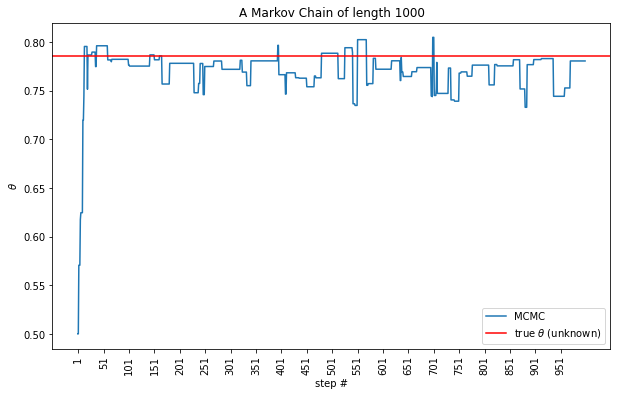

In [ ]:
def L(pi):#here we assume uniform distribution for theta
  n=len(data1)
  values=np.zeros(n)
  for i in range(0,n):
    values[i]=binom.logpmf(data1[i], 1, pi, loc=0)
  return np.sum(values)+math.log(1)

n=1000
data_MCMC=lMCMC(L,0.5,n,0.2)
plt.plot(data_MCMC,label="MCMC")
plt.xlabel("step #")
plt.xticks(np.arange(1,n+1,n/20))
plt.ylabel(r"$\theta$")
plt.axhline(y=math.pi/4, color='r', linestyle='-',label=r"true $\theta$ (unknown)")
plt.xticks(rotation = 90)
plt.legend()
plt.gcf().set_size_inches(10, 6)
plt.title("A Markov Chain of length 1000")

Text(0.5, 1.0, 'Posterior Distribution of $\theta$')

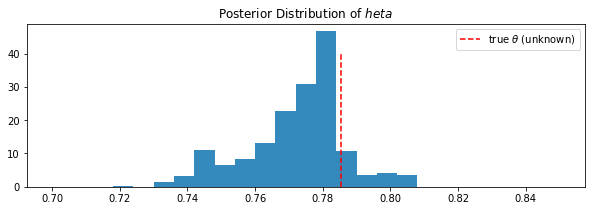

In [ ]:
figsize(10, 3)
plt.vlines(math.pi/4,0,40,linestyle='--', label=r"true $\theta$ (unknown)", color='red')
plt.hist(data_MCMC,bins=25,density=True,range=[0.7,0.85],histtype='stepfilled',color='#348ABD')
plt.legend()
plt.title("Posterior Distribution of $\theta$")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 18_000 draw iterations (2_000 + 36_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


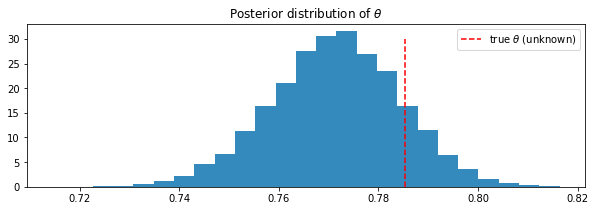

In [ ]:
def pm3(data):
  with pm.Model() as model:
    #initiate the prior distribution for θ
    theta=pm.Uniform('theta', lower=0, upper=1)

  #fit our model with the observed data
  with model:
    obs=pm.Bernoulli("obs", theta, observed=data) #input the observations
    #PyMC3 uses the Metropolis-Hastings algorithm to approximate the posterior distribution
    step=pm.Metropolis()
    #The trace function determines the number of samples withdrawn from the posterior distribution.
    trace=pm.sample(18000, step=step)
    # as the algorithm might be unstable at the beginning, 
    #it is useful to only withdraw samples after a certain period of iterations. 
    burned_trace=trace[1000:]

  #plot the posterior distribution of theta.
  p_true=math.pi/4
  figsize(10, 3)
  plt.title(r"Posterior distribution of $\theta$")
  plt.vlines(p_true,0, 30, linestyle='--', label=r"true $\theta$ (unknown)", color='red')
  plt.hist(burned_trace["theta"], bins=25, histtype='stepfilled', density=True, color='#348ABD')
  x=np.arange(0,1.04,0.04)
  # plt.plot(x, 12*x*x*(1-x), color='black')
  plt.legend()
  plt.show()
  
pm3(data1)